**Author: Pablo Ulises Hernandez Garces**

**link Github: https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-apr20-UlisesHdzG**


**Data Description**

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


**Dataset**

The project is from a dataset from Kaggle. Link to the Kaggle project site: 
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

The dataset has to be downloaded from the above Kaggle website. The dataset has the following columns:

* tweet_id
* airline_sentiment
* airline_sentiment_confidence
* negativereason
* negativereason_confidence
* airline
* airline_sentiment_gold
* name
* negativereason_gold
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location
* user_timezone

**Objective**

To implement the techniques learnt as a part of the course.

**Learning Outcomes**

* Basic understanding of text pre-processing.
* What to do after text pre-processing:
  * Bag of words
  * Tf-idf
* Build the classification model.
* Evaluate the Model.

**Steps and tasks**

1. **Import the libraries, load dataset, print shape of data, data description.**


In [23]:
!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
from google.colab import drive

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import PorterStemmer                     # Stemmer
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# loading data
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/AIML/Project 8 - NLP/Data/'
data = pd.read_csv(project_path + 'Tweets.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Data shape
data.shape

(14640, 15)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

We can see that there are some variables with null values in the dataset. However, the variables with missing values are not relevant for the objective of this project.

2. **Understand of data-columns:** 
  * Drop all other columns except “text” and “airline_sentiment”.
  * Check the shape of data.
  * Print first 5 rows of data.


In [27]:
# Dropping all columns except "text" and "airline_sentiment"
data= data.drop(data.columns[~data.columns.isin(['text','airline_sentiment'])], axis=1)

In [28]:
print('Data shape:',data.shape)
data.head()

Data shape: (14640, 2)


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


We can see that the variables of interest do not have null values.

3. **Text pre-processing: Data preparation.**
  * Html tag removal.
  * Tokenization.
  * Remove the numbers.
  * Removal of Special Characters and Punctuations.
  * Conversion to lowercase.
  * Lemmatize or stemming.
  * Join the words in the list to convert back to text string in the dataframe. (So that each row
contains the data in text format.)
  * Print first 5 rows of data after pre-processing.


In [30]:
# html tag removal
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['clean_text'] = data['text'].apply(lambda x: strip_html(x))
data.head()

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...


In [31]:
# contractions removal
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['clean_text'] = data['clean_text'].apply(lambda x: replace_contractions(x))
data.head()

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...


In [32]:
# Removing numbers
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['clean_text'] = data['clean_text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it's really aggressive to blast...,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it's a really big bad thing...,@VirginAmerica and it is a really big bad thin...


In [33]:
# tokenization
data['clean_text'] = data.apply(lambda row: nltk.word_tokenize(row['clean_text']), axis=1) 

In [34]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))   

In [35]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['clean_text'] = data.apply(lambda row: normalize(row['clean_text']), axis=1)
data.head()

,airline_sentiment,text,clean_text
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn say
1,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus add commercials experience ...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,virginamerica not today must mean need take an...
3,negative,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


4. **Vectorization:**
  * Use CountVectorizer.
  * Use TfidfVectorizer.

In [148]:
# Vectorization using CountVectorizer
vectorizer = CountVectorizer(max_features=1000)                # Keep only 2000 features as number of features will increase the processing time.
data_countVect = vectorizer.fit_transform(data['clean_text'])

data_countVect = data_countVect.toarray()                        # Convert the data features to array.
data_countVect.shape

(14640, 1000)

In [149]:
# Vectorization using TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(max_features=1000)               # Keep only 2000 features as number of features will increase the processing time.
data_tfidf = vectorizer_tfidf.fit_transform(data['clean_text'])

data_tfidf = data_tfidf.toarray()                             # Convert the data features to array.

data_tfidf.shape

(14640, 1000)

5. **Fit and evaluate model using both type of vectorization.** 


In [150]:
data['label'] = data['airline_sentiment'].map(lambda x: ({'neutral':0,'negative':1,'positive':2}).get(x))

In [151]:
pd.crosstab(index=data['label'],columns="count")     

col_0,count
label,
0,3099
1,9178
2,2363


We have an imbalanced dataset with lots of observations in negative sentiment. This will impact in the accuracy of the model. I will use 'class_weight' parameter from the model equal to 'balanced' in order to handle this problem. 

**Note:** I ran the model without using this parameter and I got the following average scores in cross validation: 73.0% for CountVect and 74.53% for TF-IDF

In [152]:
labels= data['label']
print(data_countVect.shape)
print(labels.shape)
data_countVect
labels

(14640, 1000)
(14640,)


0        0
1        2
2        0
3        1
4        1
        ..
14635    2
14636    1
14637    0
14638    1
14639    0
Name: label, Length: 14640, dtype: int64

In [153]:
# Splitting data into train and test sets
# for Countvect
X_train_countvect, X_test_countvect, y_train_countvect, y_test_countvect = train_test_split(data_countVect, labels, test_size=0.3, random_state=42)

# for TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(data_tfidf, labels, test_size=0.3, random_state=42)

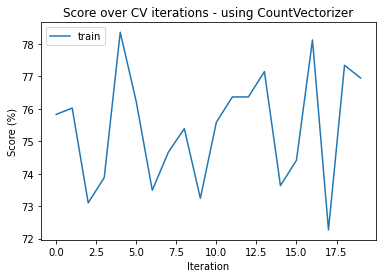

Average score (%): 75.42


In [161]:
###########
# Fitting model with CountVectorizer
###########
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
forest_countVect = RandomForestClassifier(n_estimators=50, class_weight='balanced')

forest_countVect = forest_countVect.fit(X_train_countvect, y_train_countvect)

#print(forest_countVect)

cv_res = cross_val_score(forest_countVect, X_train_countvect, y_train_countvect, cv=20)

cv_plot = pd.DataFrame({"Iteration":range(1,21),"Score CV":cv_res })
#plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(cv_plot['Score CV']*100)
plt.ylabel('Score (%)')
plt.xlabel('Iteration')
plt.legend(['train'])
plt.title('Score over CV iterations - using CountVectorizer')
plt.show()
print('Average score (%):',round( np.mean(cv_res)*100,2))

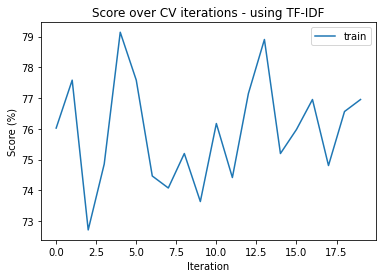

Average score (%): 75.92


In [162]:
###########
# Fitting model with TF-IDF
###########
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
forest_tfidf = RandomForestClassifier(n_estimators=50, n_jobs=4,class_weight='balanced')

forest_tfidf = forest_tfidf.fit(X_train_tfidf, y_train_tfidf)

cv_res_tfidf = cross_val_score(forest_tfidf, X_train_tfidf, y_train_tfidf, cv=20)
cv_plot_tfidf = pd.DataFrame({"Iteration":range(1,21),"Score CV":cv_res_tfidf })
#plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(cv_plot_tfidf['Score CV']*100)
plt.ylabel('Score (%)')
plt.xlabel('Iteration')
plt.legend(['train'])
plt.title('Score over CV iterations - using TF-IDF')
plt.show()
print('Average score (%):',round( np.mean(cv_res_tfidf)*100,2))

In [163]:
# predictions

# CountVectorizer
y_pred_countvect = forest_countVect.predict(X_test_countvect)

# TF-IDF
y_pred_tfidf = forest_tfidf.predict(X_test_tfidf)

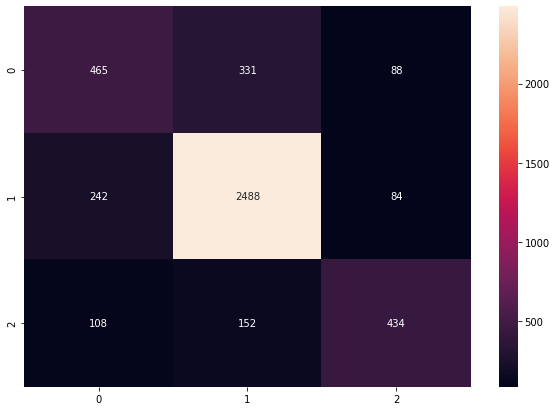

In [164]:
# Confusion matrix
conf_mat_countvect = confusion_matrix(y_test_countvect, y_pred_countvect)
conf_mat_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf)

df_cm_countvect = pd.DataFrame(conf_mat_countvect)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_countvect, annot=True, fmt='g')

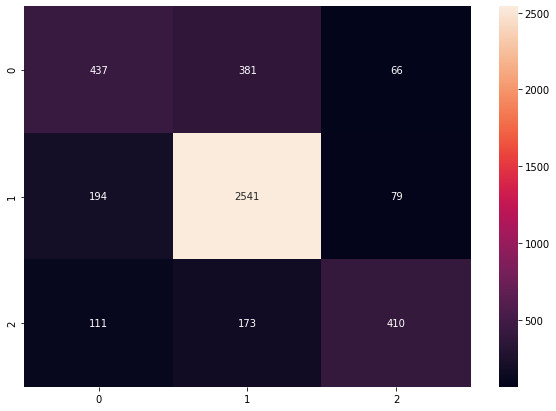

In [165]:
df_cm_tfidf = pd.DataFrame(conf_mat_tfidf)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_tfidf, annot=True, fmt='g')

In [166]:
# Scores per category: Using CountVect
print('Accuracy countVect model: '+ str(accuracy_score(y_test_countvect  ,y_pred_countvect)))
print('Recall_score countVect model: ' + str(recall_score(y_test_countvect,y_pred_countvect, average=None)))
print('Precision_score countVect model: ' + str(precision_score(y_test_countvect, y_pred_countvect,average=None)))
print('F1-score countVect model: ' + str(f1_score(y_test_countvect,y_pred_countvect,average=None)))


Accuracy countVect model: 0.7711748633879781
Recall_score countVect model: [0.5260181  0.88415068 0.62536023]
Precision_score countVect model: [0.57055215 0.83742848 0.71617162]
F1-score countVect model: [0.54738081 0.86015557 0.66769231]


In [167]:
# Scores per category: Using TF-IDF
print('Accuracy TF-IDF model: '+ str(accuracy_score(y_test_tfidf  ,y_pred_tfidf)))
print('Recall_score TF-IDF model: ' + str(recall_score(y_test_tfidf,y_pred_tfidf, average=None)))
print('Precision_score TF-IDF model: ' + str(precision_score(y_test_tfidf, y_pred_tfidf,average=None)))
print('F1-score TF-IDF model: ' + str(f1_score(y_test_tfidf,y_pred_tfidf,average=None)))


Accuracy TF-IDF model: 0.7714025500910747
Recall_score TF-IDF model: [0.49434389 0.90298507 0.5907781 ]
Precision_score TF-IDF model: [0.58894879 0.82100162 0.73873874]
F1-score TF-IDF model: [0.53751538 0.860044   0.65652522]


6. **Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset.**

In the pre-processing steps I followed, there are some elements that help to improve the performance of the models. For example, removing some stop words related to negative meaning (such as not, couldn't, didn't, etc.) from the stop words set helps the model to identify pretty well the tweets with a negative sentiment. Additionally, this is really important because there are a lot more negative than neutral or positive tweets. Moreover, for the Airline company it is valuable to understand the issues described in the negative tweets in order to solve them. In other words, the problem to solve is understand what the airline is doing bad and how they can improve their service to reduce bad comments and continuing with the good things. If I had not removed those stop words, the model could not have learnt about the negative sentiment of lots of tweets because of the lack of context given by the stop words removed.

The rest of the steps of pre-processing are necessary for having a clean dataset, such as html tags removal, removing contractions, punctuation, numbers and non-ascii characters and converting each word to lowercase. Having implemented these steps we have a more interpretable data, in terms of standard English. Additionally, tokenization is needed to implement all those steps mentioned before to each word.

The last part of the pre-processing I implemented was lemmatization. This is a key part of the process. Due to this, models could perform well. In contrast, if I had implemented stemming, performance of models would have been affected because some context had been lost (a disadvantage of stemming compared to lemmatization). Additionally, running time has not been affected for doing lemmatization. 

On the other hand, vectorization plays an important role in natural language processing. It is a step that we must do in order to feed our models with data and that computers could interpret it. In my process, I implemented both CounVect and TF-IDF vectorizations and also play with some different numbers of max features, I found that with too low or too high numbers of features perform bad in my models, so I kept only 1000 features that seems to be a good number for this problem. And this can be explained as the model could not learned from very few features because the complexity of the problem requires more features(distinct words) but neither from a very large number of distinct words because we would have so many features than the model could not differentiate one 
observation from another (we would have a sparse matrix).

In terms of the performance of the models, both of them (countVect and TF-IDF) had good scores. However, countVect performs a little more better than TF-IDF in almost all the metrics I showed, but TF-IDF predicted correctly more negative sentiment tweets thant countVect.

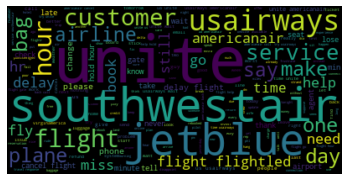

In [195]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# filtering those tweets with negative sentiment of the test set in order to visualize what are the problems
index = y_pred_tfidf==1
negative_tweets= X_test_countvect[index]
aux = vectorizer_tfidf.inverse_transform(negative_tweets)

for i in range(0,negative_tweets.shape[0]):
  aux[i]=' '.join(aux[i])
words = " ".join(aux)
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Finally, from the above wordcloud we can see what are the most frequent words that tweets with negative sentiment have. We can see some related to time like "hour", "delay", "late", etc. Additionally, there are some others related to the service like "help", "book", "change", etc. So, these words could help airline to understand that most of the complains of the customers are related to the time and the quality of the service in the desk or in the call center. With this, airline could implement some strategies to improve their customer services and strictly follow  the schedules.